# Analysis of neuron_labeling dataset from scNT-seq

Here you will learn how to analyze the neuron_labeling dataset from scNT-seq using the CSP model with steady-state assumptions (CSPss) and comparing it to Dynamo method.

In [1]:
import warnings

warnings.filterwarnings('ignore')

import dynamo as dyn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and preprocess the data

In [2]:
# filename = './data/scNT_seq.h5ad'
filename = './data/neuron_labeling.h5ad'
neuron_labeling = dyn.read_h5ad(filename)

In [3]:
neuron_labeling

AnnData object with n_obs × n_vars = 3060 × 24078
    obs: 'cell_type', '4sU', 'treatment', 'time', 'cell_name'
    var: 'gene_short_name', 'activity_genes'
    layers: 'new', 'total'

In [4]:
neuron_labeling.obs['label_time'] = 2  # this is the labeling time
tkey = 'label_time'

peng_gene_list = pd.read_csv('./data/0408_grp_info.txt', sep='\t') # subset datasets with neural activity genes

neuron_labeling = neuron_labeling[:, peng_gene_list.index]
neuron_labeling.obs['time'] = neuron_labeling.obs.time.astype('category')

In [5]:
dyn.pp.recipe_monocle(neuron_labeling, 
                      keep_raw_layers=True, 
                      n_top_genes=1000, 
                      experiment_type='one-shot', 
                      tkey=tkey,
                     )

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> detected experiment type: one-shot
|-----------> <insert> tkey to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type to uns['pp'] in AnnData Object

## Use CSPss and Dynamo methods to infer parameters and calculate total velocity, respectively.

In [6]:
neuron_labeling_CSPss = neuron_labeling.copy()
neuron_labeling_Dynamo = neuron_labeling.copy()
del neuron_labeling

In [7]:
# for CSP with steady state
neuron_labeling_CSPss.uns["pp"]["experiment_type"] = 'kin'
dyn.tl.dynamics(neuron_labeling_CSPss, est_method='CSP4ML_CSPss', model='deterministic', tkey=tkey)
dyn.tl.reduceDimension(neuron_labeling_CSPss)
dyn.tl.cell_velocities(neuron_labeling_CSPss, ekey='M_t', vkey='velocity_T', enforce=True)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [9.6543s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.
|-----> experiment type: kin, method: CSP4ML_CSPss, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 97it [00:00, 1559.13it/s]
Infer parameters via maximum likelihood estimation based on the CSP model under the steady-state assumption: 97it [00:00, 1954.28it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [15.0813s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|

AnnData object with n_obs × n_vars = 3060 × 97
    obs: 'cell_type', '4sU', 'treatment', 'time', 'cell_name', 'label_time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'ntr'
    var: 'gene_short_name', 'activity_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'gamma_k', 'gamma_r2', 'gamma_r2_raw', 'prob_off', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap'
    obsm: 'X_pca', 'X', 'X_umap', 'velocity_umap'
    layers: 'new', 'total', 'X_new', 'X_total', 'M_t', 'M_tt', 'M_n', 'M_tn', 'M_nn', 'M_CSP_t', 'M_CSP_n', 'velocity_N', 'velocity_T', 'cell_wise_alpha'
    obsp: 'moments_co

In [8]:
# for Dynamo
dyn.tl.dynamics(neuron_labeling_Dynamo, model='deterministic', tkey=tkey)
dyn.tl.reduceDimension(neuron_labeling_Dynamo)
dyn.tl.cell_velocities(neuron_labeling_Dynamo, ekey='M_t', vkey='velocity_T', enforce=True)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [6.2665s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating gamma: 100%|████████████████████████| 97/97 [00:00<00:00, 203.59it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [12.7037s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|

AnnData object with n_obs × n_vars = 3060 × 97
    obs: 'cell_type', '4sU', 'treatment', 'time', 'cell_name', 'label_time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'ntr'
    var: 'gene_short_name', 'activity_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap'
    obsm: 'X_pca', 'X', 'X_umap', 'velocity_umap'
    varm: 'alpha'
    layers: 'new', 'total', 'X_new', 'X_total', 'M_t', 'M_tt', 'M_n', 'M_tn', 'M_nn', 'M_CSP_t', 'M_CSP_n

## Visualization

Change the settings for better visualization:

In [14]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
sc.set_figure_params(scanpy=True, fontsize=6)
figsize = (6, 4)
dpi = 600
path = './one-shot/streamline/'

### Streamline plots in UMAP space

<Figure size 600x400 with 0 Axes>

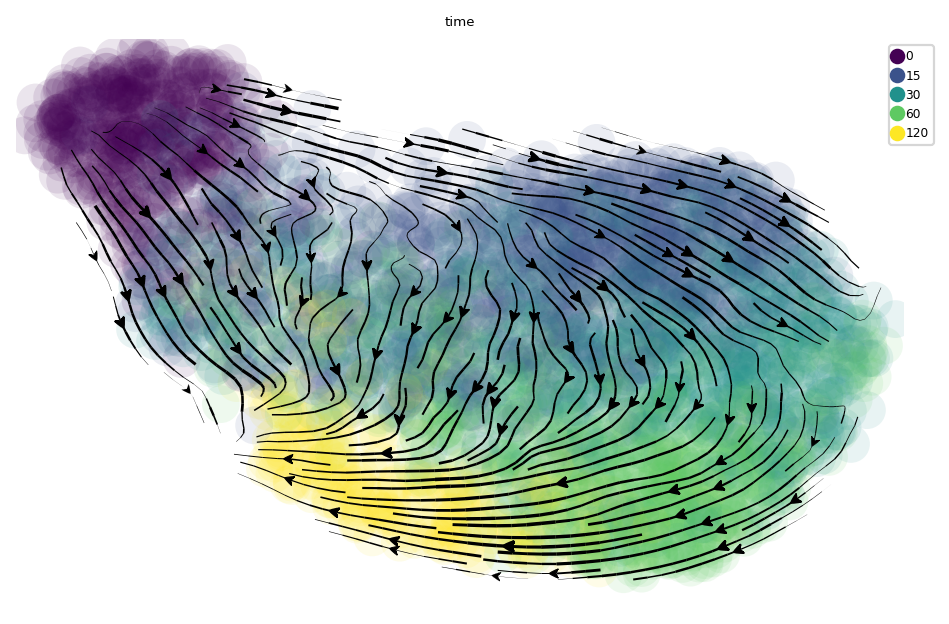

In [15]:
# CSP with steady-state
dyn.pl.streamline_plot(neuron_labeling_CSPss, color='time', color_key_cmap='viridis', basis='umap', show_legend='right',
                       save_show_or_return='show', save_kwargs={'prefix': 'neuronal_activity_umap_cspss', 'ext': 'png',
                        "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize
                       )

<Figure size 600x400 with 0 Axes>

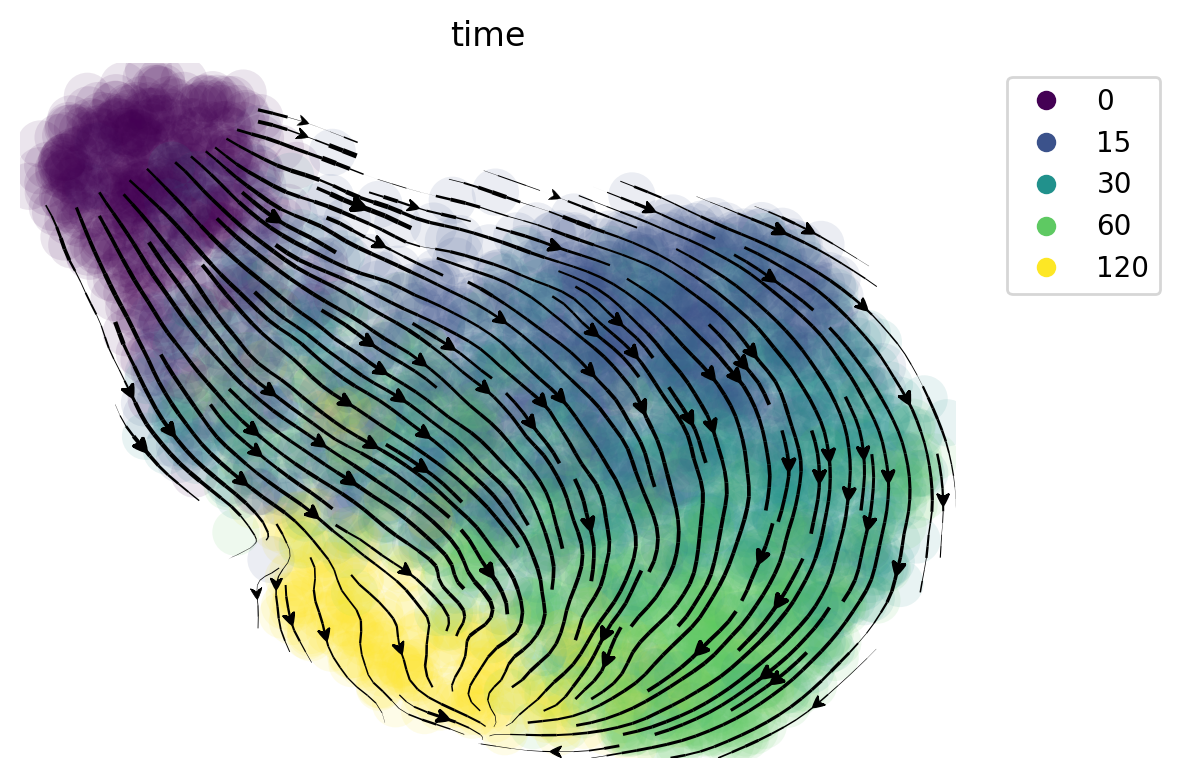

In [16]:
# Dynamo
dyn.pl.streamline_plot(neuron_labeling_Dynamo, color='time', color_key_cmap='viridis', basis='umap', show_legend='right',
                       save_show_or_return='show', save_kwargs={'prefix': 'neuronal_activity_umap_dynamo', 'ext': 'png',
                        "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize
                       )

### Plot the inferred results of $\gamma_{t}$ of the two methods

In [12]:
gamma_CSPss = neuron_labeling_CSPss.var['gamma'].values
gamma_Dynamo = neuron_labeling_Dynamo.var['gamma'].values

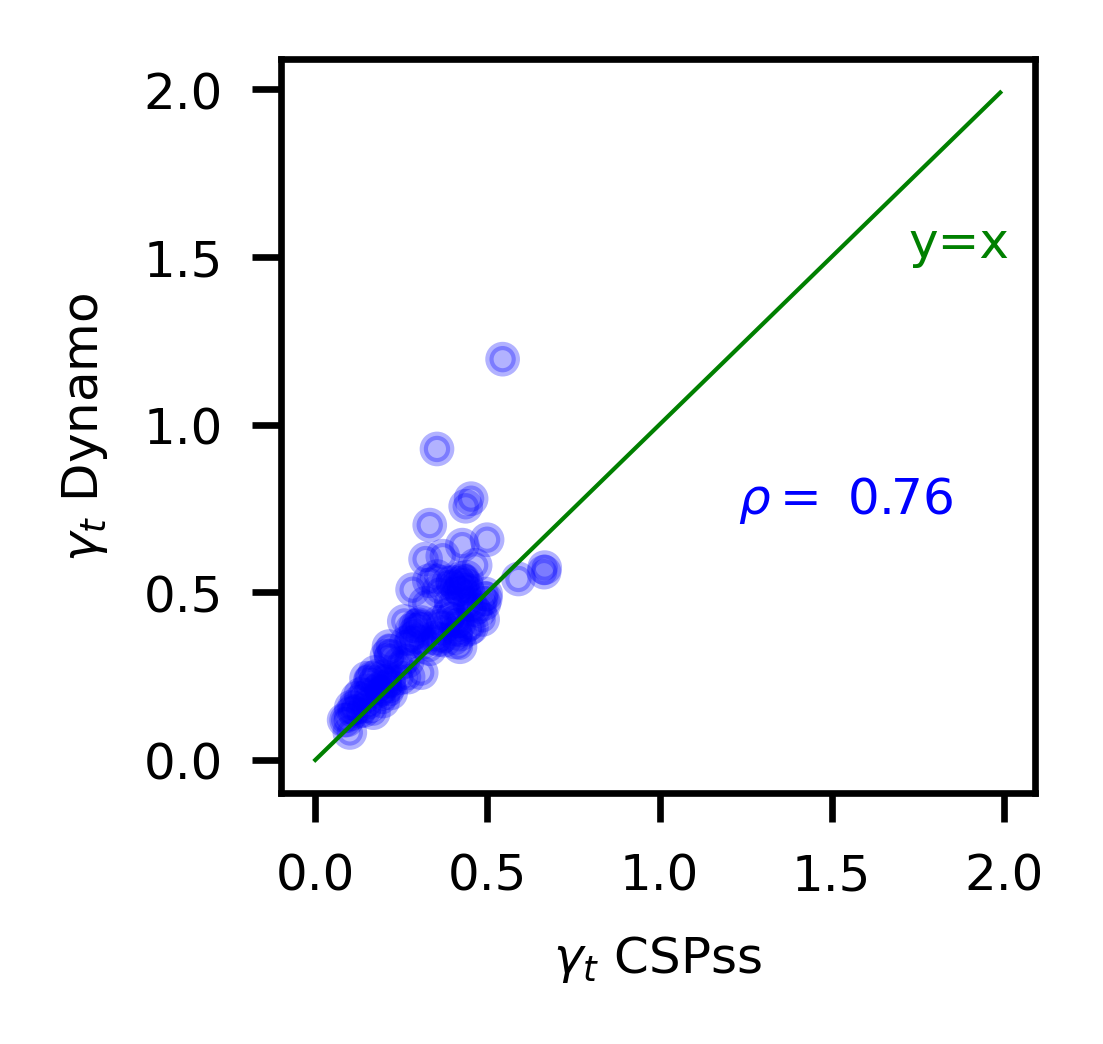

In [13]:
sc.set_figure_params(scanpy=True, fontsize=6)
scatter_size = 10
figsize = (1.61, 1.61)
alpha = 0.3
dpi = 300

gamma_CSPss = gamma_CSPss.astype('float')
gamma_Dynamo = gamma_Dynamo.astype('float')


range_min = 0
range_max = 2
x = np.arange(range_min, range_max, 0.01)
y = x

index_no_nan = np.logical_and(np.isfinite(gamma_CSPss), np.isfinite(gamma_Dynamo))
# correlation coefficient between all the genes
rho = np.corrcoef(gamma_CSPss[index_no_nan], gamma_Dynamo[index_no_nan])


fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(gamma_CSPss, gamma_Dynamo, color='blue', s=scatter_size * np.ones(len(gamma_CSPss)), alpha=alpha)
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho=$ %4.2f' % rho[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.xlabel('$\gamma_t$ CSPss')
plt.ylabel('$\gamma_t$ Dynamo')
plt.grid(False)
plt.savefig('./one-shot/comp/neuron_labeling.pdf',dpi=dpi, bbox_inches="tight")
plt.show()